# seq2seq 번역기

## 루브릭 
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.  
구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

In [113]:
str(df_rm_dup['ko'][0])

"['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?']"

2. Attentional Seq2seq 모델이 정상적으로 구동된다.	     
seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.  

학습 진행도
```text
Epoch  1: 100%|██████████| 1019/1019 [18:59<00:00,  1.12s/it, Loss 1.7195]
Epoch  2: 100%|██████████| 1019/1019 [16:36<00:00,  1.02it/s, Loss 1.4677]
... 중략 ...
Epoch  9: 100%|██████████| 1019/1019 [16:39<00:00,  1.02it/s, Loss 0.7694]
Epoch 10: 100%|██████████| 1019/1019 [16:39<00:00,  1.02it/s, Loss 0.7026]
```

3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	    
테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.  

예문 번역
```text
Input: 오바마는 대통령이다.
Predicted translation: obama is the president . <end> 
Input: 시민들은 도시 속에 산다.
Predicted translation: people in the city . <end> 
Input: 커피는 필요 없다.
Predicted translation: it s not a caffeine <end> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed . <end> 
```


In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

## 데이터

* 데이터 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [2]:
with open("data/korean-english-park.train.ko", "r") as f:
    ko = f.read().splitlines()

In [3]:
with open("data/korean-english-park.train.en", "r") as f:
    en = f.read().splitlines()

### 중복 처리
한글 영문 데이터를 쌍으로 봐야하기 때문에 데이터프레임으로 만들어서 처리

In [4]:
df = pd.DataFrame({"ko": ko, "en": en})
df.shape

(94123, 2)

In [5]:
# # 한국어 기준으로 중복 확인
df[df["ko"].duplicated() == True]

,ko,en
30,어휘 :,Postal Service - whose postmaster told a Senat...
282,어휘 :,the United States will take every measure agai...
1456,어휘 :,aid groups set up freshwater tanks to provide ...
2226,어휘 :,communications with the tiny $4.5 million DASH...
3003,어휘 :,The upper end of that range would put SG344 on...
...,...,...
94016,국회의사당에서 제리 보드랜더였습니다.”,"Jerry Bodlander, Capitol Hill.”"
94024,TOEIC 독해,The vote is expected late today.
94050,"Bush hails ´major shift´ in Iraq 부시, 이라크에 ‘중대한...",Thousands of Burmese risk the trip to Thailand...
94093,AP 라디오 뉴스입니다.,a national average $2.42 a gallon.


In [6]:
# 한국어 기준으로 중복 제거
df_rm_dup = df.drop_duplicates(["ko"])

In [7]:
# 제거되었는지 확인
df_rm_dup[df_rm_dup["ko"].duplicated() == True]

,ko,en


In [8]:
df_rm_dup.shape

(77591, 2)

### 전처리

In [1]:
import re


def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()  # 소문자화

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 기호처리
    sentence = re.sub(r'[" "]+', " ", sentence)  # 연속 공백 처리
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)  # 기타 문자 제거

    sentence = sentence.strip()  # 양쪽 공백 제거

    # 토큰추가
    if s_token:
        sentence = "<start> " + sentence

    if e_token:
        sentence += " <end>"

    return sentence

In [10]:
df_rm_dup.loc[:, "ko"] = df_rm_dup["ko"].apply(lambda x: preprocess_sentence(x))
df_rm_dup.loc[:, "en"] = df_rm_dup["en"].apply(
    lambda x: preprocess_sentence(x, s_token=True, e_token=True)
)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


### 토큰화

In [11]:
from konlpy.tag import Mecab

mecab = Mecab()

# 윈도우의 경우
# mecab = Mecab(dicpath=r"C:\mecab\share\mecab-ko-dic")

In [12]:
mecab.morphs("무궁화꽃이피었습니다")

['무궁화', '꽃', '이', '피', '었', '습니다']

In [13]:
# 한글은 mecab 사용
df_rm_dup.loc[:, "ko"] = df_rm_dup["ko"].apply(lambda x: mecab.morphs(x))

In [14]:
# 영어는 공백기준 토큰화
df_rm_dup.loc[:, "en"] = df_rm_dup["en"].apply(lambda x: x.split())

In [15]:
# 토큰화 결과 확인
df_rm_dup.head()

,ko,en
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, like, all, optical, mice, ,, but, it..."
3,"[., 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서, 팔...","[<start>, uses, gyroscopic, sensors, to, contr..."
4,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...","[<start>, intelligence, officials, have, revea..."


### 짧은 문장만 사용

1만개 정도 줄어듦

In [16]:
# 연산시간 낭비 줄이기
df_short = df_rm_dup[df_rm_dup["ko"].apply(len) <= 40]

In [17]:
df_short.shape

(65162, 2)

### 텐서화

In [18]:
NUM_WORDS = 20000

In [19]:
# 패딩 및 텐서로 변환
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, filters="")
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post")

    return tensor, tokenizer

In [20]:
ko_tensor, ko_tokenizer = tokenize(df_short["ko"])
en_tensor, en_tokenizer = tokenize(df_short["en"])

## 모델

In [5]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)

    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        # 인코더 출력을 Dense 레이어를 통해 변환
        h_enc = self.w_enc(h_enc)
        # 디코더 상태의 차원을 맞추기 위해 차원을 확장, [batch x units] -> [batch x 1 x units]
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)  # 디코더 상태를 Dense 레이어를 통해 변환

        # 어텐션 스코어 계산, [batch x length x 1]. w_com의 크기가 1이기 때문
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        # 스코어를 가중치로 변환, [batch x length x 1]
        attn = tf.nn.softmax(score, axis=1)

        # 인코더 각 단어에 가중치 적용하여 맥락벡터 생성
        context_vec = attn * h_enc
        # [batch x length x units] -> [batch x units]
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, dropout=0.1)

    def call(self, x):
        result = self.embedding(x)
        result = self.gru(result)

        return result

In [7]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            dec_units, return_sequences=True, return_state=True, dropout=0.1
        )
        self.attention = BahdanauAttention(dec_units)
        self.dense = tf.keras.layers.Dense(vocab_size)

        # 한번에 한 단어씩 처리하기 때문에 sequence_length = 1
    def call(self, x, h_dec, enc_out):
        result = self.embedding(x)  # [batch, sequence_length, embedding_dim]
        context_vec, attn = self.attention(enc_out, h_dec)

        # [batch x units] -> [batch x 1 x units] + [batch, sequence_length, embedding_dim]
        # = > [batch, sequence_length, embedding_dim + units]
        result = tf.concat([tf.expand_dims(context_vec, 1), result], axis=-1)

        # result : [batch_size, sequence_length, dec_units]
        # h : [batch_size, dec_units]
        result, h = self.gru(result)

        # result : [batch_size * sequence_length, dec_units]
        result = tf.reshape(result, (-1, result.shape[2]))

        result = self.dense(result)  # [batch_size * sequence_length, vocab_size]

        return result, h, attn

In [10]:
BATCH_SIZE = 64
SRC_VOCAB_SIZE = NUM_WORDS + 1  # 단어사전 + 1이기 때문에 이게 적합하다고 판단
TGT_VOCAB_SIZE = NUM_WORDS + 1

# oom 때문에 축소
units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print("Encoder Output:", sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(
    tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output
)

print("Decoder Output:", sample_logits.shape)
print("Decoder Hidden State:", h_dec.shape)
print("Attention:", attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 20001)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


### 훈련

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    # 마스킹 처리 : 숫자가 아닌 패딩 등의 토큰의 경우 마스킹하여 스킵
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [26]:
@tf.function  # gpu연산
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]  # 배치사이즈
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)

        # 처음에 디코더의 초기 상태는 인코더의 최종 상태로 설정
        h_dec = enc_out[:, -1]

        # 디코더 입력토큰
        dec_src = tf.expand_dims([dec_tok.word_index["<start>"]] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = loss / int(tgt.shape[1])

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [27]:
from tqdm import tqdm  # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, ko_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)  # tqdm

    for batch, idx in enumerate(t):
        batch_loss = train_step(
            ko_tensor[idx : idx + BATCH_SIZE],
            en_tensor[idx : idx + BATCH_SIZE],
            encoder,
            decoder,
            optimizer,
            en_tokenizer,
        )

        total_loss += batch_loss

        t.set_description_str("Epoch %2d" % (epoch + 1))  # tqdm
        t.set_postfix_str("Loss %.4f" % (total_loss.numpy() / (batch + 1)))  # tqdm

Epoch 10: 100%|██████████| 1019/1019 [16:39<00:00,  1.02it/s, Loss 0.7026]


### 모델 평가 

In [103]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((en_tensor.shape[-1], ko_tensor.shape[-1]))

    sentence = preprocess_sentence(sentence)
    sentence = mecab.morphs(sentence)

    inputs = ko_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        inputs, maxlen=ko_tensor.shape[-1], padding="post"
    )

    result = ""

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([en_tokenizer.word_index["<start>"]], 0)

    for t in range(en_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input, dec_hidden, enc_out
        )

        attention_weights = tf.reshape(attention_weights, (-1,))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += en_tokenizer.index_word[predicted_id] + " "

        if en_tokenizer.index_word[predicted_id] == "<end>":
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap="viridis")

    fontdict = {"fontsize": 14}

    ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder,show_plot=False):
    original_sentence = sentence
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print("Input: %s" % (original_sentence))
    print("Predicted translation: {}".format(result))
    if show_plot:
        attention = attention[: len(result.split()), : len(sentence)]
        plot_attention(attention, sentence, result.split(" "))

#### 예문 번역

In [83]:
plt.rc('font', family='NanumBarunGothic') 

Input: 오바마는 대통령이다.
Predicted translation: obama is the president . <end> 


/tmp/ipykernel_47/1451168171.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_47/1451168171.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)


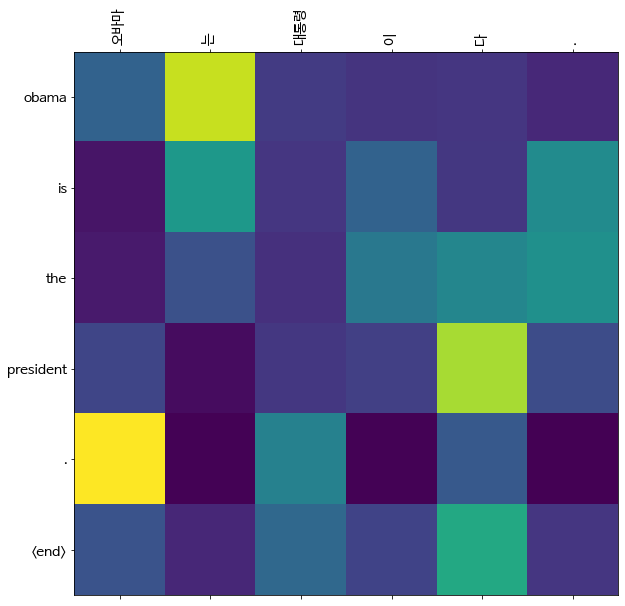

Input: 시민들은 도시 속에 산다.
Predicted translation: people in the city . <end> 


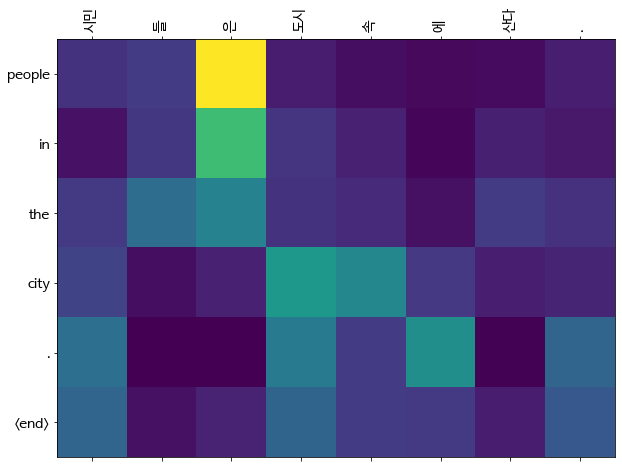

Input: 커피는 필요 없다.
Predicted translation: it s not a caffeine <end> 


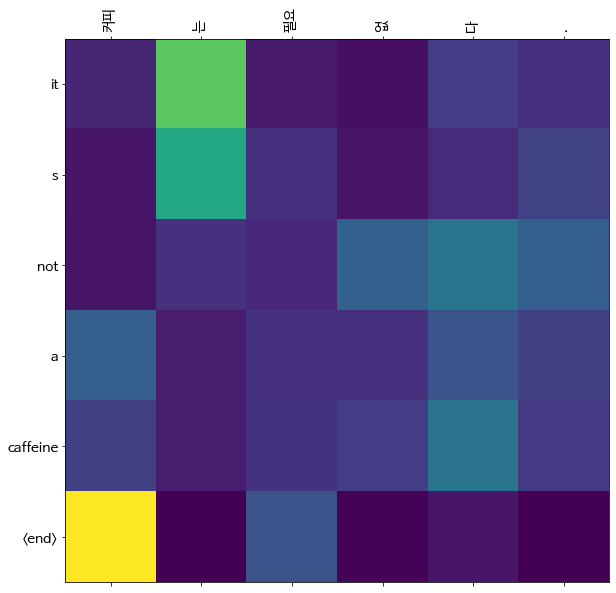

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed . <end> 


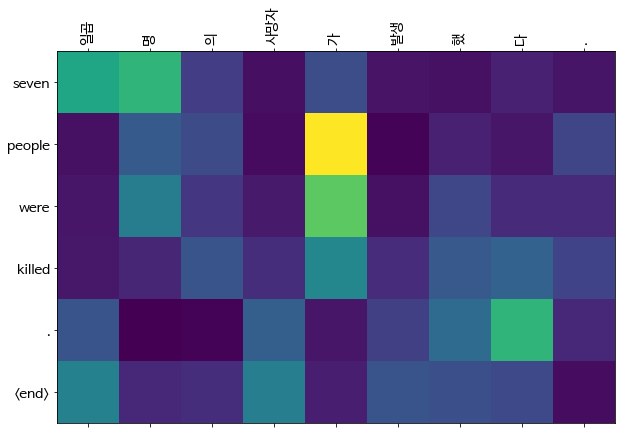

In [84]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.'
             ,'커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']
for s in sentences:
    translate(s, encoder, decoder, show_plot=True)

여러 문장 번역해보기

In [104]:
# 일상대화
translate('좋은 아침입니다.', encoder, decoder)

Input: 좋은 아침입니다.
Predicted translation: good time good for good . <end> 


In [117]:
translate('파리에 갈 예정입니다.', encoder, decoder)

Input: 파리에 갈 예정입니다.
Predicted translation: the hollywood will be the third of paris . <end> 


In [119]:
translate('여행을 가고 싶어요.', encoder, decoder)

Input: 여행을 가고 싶어요.
Predicted translation: i want to wait . <end> 


In [115]:
# lms 지침 
translate('번역기 만들기', encoder, decoder)

Input: 번역기 만들기
Predicted translation: the industry is to your buck . <end> 


In [109]:
# 뉴스
translate('밤부터 집중 호우가 내릴 것으로 예보됐습니다.', encoder, decoder)

Input: 밤부터 집중 호우가 내릴 것으로 예보됐습니다.
Predicted translation: the remnants are expected to arrive in the night <end> 


In [122]:
translate('지구에서 약 63광년 떨어진 우주에 있는 한 행성', encoder, decoder)

Input: 지구에서 약 63광년 떨어진 우주에 있는 한 행성
Predicted translation: the sun is being released years . <end> 


In [123]:
translate('2월에 실시된 신체검사를 포함해 세 번의 연례 신체검사에서 바이든의 신경학적 검사를 수행했다고 서한에 썼다. ', encoder, decoder)

Input: 2월에 실시된 신체검사를 포함해 세 번의 연례 신체검사에서 바이든의 신경학적 검사를 수행했다고 서한에 썼다. 
Predicted translation: the panel has been suspended , the associated press reported . <end> 


In [144]:
# 학습데이터 번역해보기
for i in range(10):
    print(f"\n{i+1}번째 번역")
    translate(df['ko'][i], encoder, decoder)


1번째 번역
Input: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Predicted translation: the user s a brighter computer <end> 

2번째 번역
Input: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
Predicted translation: all the offending laptops are in a rechargeable wireless optical mouse . <end> 

3번째 번역
Input: 그러나 이것은 또한 책상도 필요로 하지 않는다.
Predicted translation: but it also do not do . <end> 

4번째 번역
Input: 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
Predicted translation: the user is a sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the sensor that touches the sensor for the 

5번째 번역
Input: 정보 관리들은 동남 아시아에서의

#### 학습 실패 사례

```text
num words 10000, units = 1024, embedding_dim = 512  : 학습이 진행이 안됨

Epoch  1: 100%|██████████| 1019/1019 [07:35<00:00,  2.24it/s, Loss 1.8804] 
Epoch  2: 100%|██████████| 1019/1019 [05:01<00:00,  3.39it/s, Loss 1.8669]
Epoch  3: 100%|██████████| 1019/1019 [05:00<00:00,  3.39it/s, Loss 1.8670]
Epoch  4: 100%|██████████| 1019/1019 [05:04<00:00,  3.34it/s, Loss 1.8668]
Epoch  5: 100%|██████████| 1019/1019 [05:11<00:00,  3.27it/s, Loss 1.8663]


```


### 결론 및 회고

처음에는 일단 학습을 하고 하이퍼 파라미터를 변경하면서 epoch마다 번역 상태를 보려고 했는데, 처음 시도가 학습이 아예 안되었고, 2 번째 시도 학습이 생각보다 오래걸려서 결국 학습 경과에 따른 번역 상태를 확인해보지 못해서 아쉬웠다.  
그래도 학습이 완료되고 예문을 번역하였을 때 성능이 생각보다 좋아서 깜짝 놀랐다. 그래서 이게 말이 안된다고 생각을 하고 다른 문장을 번역해보니 역시나 별로인 성능을 볼 수 있었다. 어떤 기준으로 예문을 준 건지는 몰라도 어느정도 학습이 되는 문장을 준 것 같았다.
> 퍼실님께서 선별된 문장은 아니고 임의의 문장이라고 하셨다.   
결과를 보시고 운이 좋은 경우일 거라고 하셔서 당황스럽다. 

그래도 번역이 이상한 문장 중에 일부분만 잘 된 케이스도 있고, 문법적으로 완전히 이상한 경우는 적어서 어느정도 모델의 성능은 잘 나온 것 같았다. 다만 학습 데이터를 그대로 모델에 돌려서 결과를 보면 같은 단어가 연속적으로 나오는 케이스도 많이 있는거 같았다. 원문 문장이 좀 복잡하면 그런 현상이 심했는데, 6번째 번역을 보면 꼭 그렇지만도 않았다. 

지금까지 연산 속도 자체는 lms보다 로컬이 빠른 경향이 있어서 로컬로 돌리다가 vram이 12기가 밖에 안되어서 결국 로컬에서 돌리는 것을 포기하고 lms에서 돌리게 되었다. 왜 그렇게 인공지능에서 vram을 중요시 하는 지 체감할 수 있는 경험이 되었다.   
